In [1]:
import lightkurve as lk
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as plt
import pandas as pd

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import starry
import pdb
from astropy import constants as const
from astropy import units as u

%matplotlib inline

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
df = pd.read_csv('/Users/tuca/Desktop/EPIC_exoplanet_research_2023/detrended_lc.csv', header = 0,
                 names = ['time', 'flux', 'flux_error', 'Kepler'])


time = (df['time'] - 2454833).values
flux = df['flux'].values
flux_error = df['flux_error'].values

In [3]:
time = (df['time'] - 2454833).values
flux = df['flux'].values
flux_error = df['flux_error'].values

In [4]:
# plt.plot(time, flux, 'k')
# print(np.min(time))
# plt.xlim(2384, 2464)
# plt.ylim(0.9967,1.001)


(0.9812, 1.0009850304)

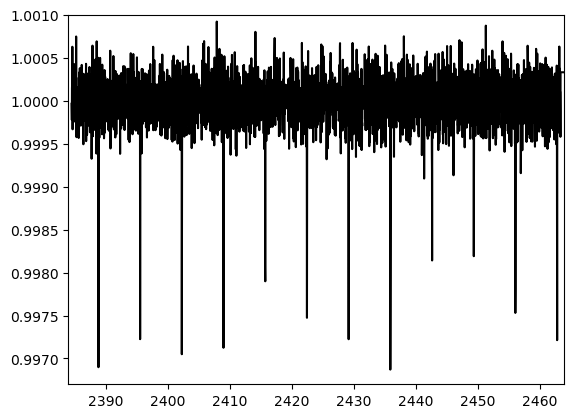

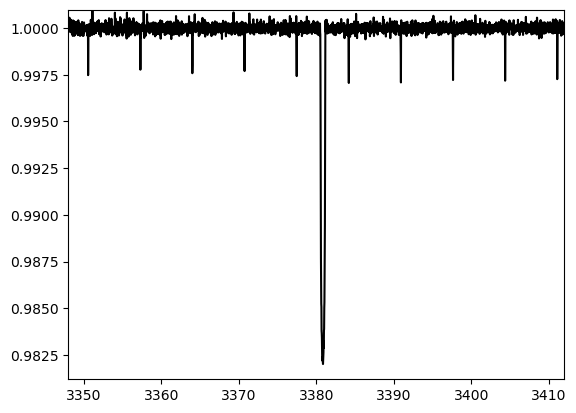

In [5]:
plt.figure()
plt.plot(time, flux, 'k')
# print(np.min(time))
plt.xlim(2384, 2464)
plt.ylim(0.9967,1.001)

plt.figure()
plt.plot(time, flux, 'k')
# print(np.min(time))
plt.xlim(3348, 3412)
plt.ylim(0.9812, flux.max())

In [6]:
periods = [6.7252337648, 1000]
period_error = [0.1, 500]
t0s = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833] #[2388.835, 3380.822]
t0_error = [0.1, 0.1]
duration = [0.9/24, 15.71/24]
nplanets = 2
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88
ecc_fit = True

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((const.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (const.R_sun).to(u.au).value

#pdb.set_trace()

with pm.Model() as model:

    mean = pm.Normal("mean", mu=0.0, sigma=1.0, testval = 1)
    ustar = xo.distributions.QuadLimbDark("u")
    
    # Stellar parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
    m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
    r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
    teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
    st_lum = pm.Deterministic("st_lum", (r_star**2) * ((teff/5777)**4)) #stellar luminosity #derived parameter
    star_params = [mean, ustar] 
    
    # Planet parameters
    ror = pm.Uniform("ror", lower=0.01, upper = 0.99, shape=nplanets) #, testval=np.array([0.04, 0.06]))
    r_pl = pm.Deterministic("r_pl", ror*r_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step
#     m_pl = pm.Uniform("m_pl", lower=0.1, upper=3e4, testval=Expected_msini, shape=nplanets)
#     # deterministic means values that were derived from the model
#     density_pl = pm.Deterministic("density_pl", m_pl/((r_pl*Rsun2Rearth)**3) * 5.514) # Convert from rho_earth to g/cm3

    # Orbital parameters
    period = pm.Normal("period", mu = np.array(periods), sigma= np.array(period_error), shape=nplanets)
    t0 = pm.Normal("t0", mu=t0s, sigma=np.array(t0_error), shape=nplanets)
    b = pm.Uniform("b", lower = 0, upper = 1, shape=nplanets)
    
    # Set up the orbit
    #orbit = xo.orbits.KeplerianOrbit(period=period, ror = ror, duration=dur, t0=t0, b=b)

    if ecc_fit:
        # for an eccentric orbit # 
        ecs = pmx.UnitDisk("ecs", testval=np.array([[0.1, 0.1]] * nplanets).T, shape=(2, nplanets))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    else:
        # for circular orbit #
        ecc = np.repeat(0, nplanets)
        omega = np.repeat(np.pi/2, nplanets)

    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(r_star = r_star, m_star= m_star, 
                                     period = period, t0 = t0, b = b, 
                                     ecc = ecc, omega = omega) #m_planet = xo.units.with_unit(m_pl, u.M_earth))
    pm.Deterministic("rho_circ", orbit.rho_star)
    pm.Deterministic("aor", orbit.a / r_star)
    
    ######## Set up the mean transit model
    star = xo.LimbDarkLightCurve(ustar)
    light_curves = star.get_light_curve(orbit=orbit, r=r_pl, t=time, texp = 29.4*u.min.to('d'))#calculates lc for each planet at its time vector    
    pm.Deterministic("light_curves", light_curves) #saves the individual lightcurves
    lc_model = mean + tt.sum(light_curves, axis=-1) #full photometric model, the sum of all transits + the baseline (mean)
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=lc_model, sd=flux_error, observed=flux)
    
    map_soln = model.test_point
    print(model.check_test_point())
    map_soln = pmx.optimize(map_soln, [ror, b])
    map_soln = pmx.optimize(map_soln, [t0, period])
    if ecc_fit:
        map_soln = pmx.optimize(map_soln, vars = ecs)
    map_soln = pmx.optimize(map_soln)
    
#     map_soln = pmx.optimize(map_soln, [r_pl, b, dur])
#     map_soln = pmx.optimize(map_soln, star_params)


mean                             -1.42
u_quadlimbdark__                 -2.77
m_star_interval__                -1.12
r_star_interval__                 0.01
teff_interval__                  -7.10
ror_interval__                   -2.77
period                           -5.75
t0                                2.77
b_interval__                     -2.77
ecs_unitdisk+interval__          -2.82
obs                       -35752788.64
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [b, ror]


message: Desired error not necessarily achieved due to precision loss.
logp: -35752812.38948273 -> 46834.98873099079
optimizing logp for variables: [period, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 46834.98873099079 -> 46835.403966483034
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: 46835.403966483034 -> 46835.68242521333
optimizing logp for variables: [ecs, b, t0, period, ror, teff, r_star, m_star, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 46835.68242521333 -> 46858.25236970919


# Plotting the maximum a posteriori model to make sure that our initialization looks ok... #

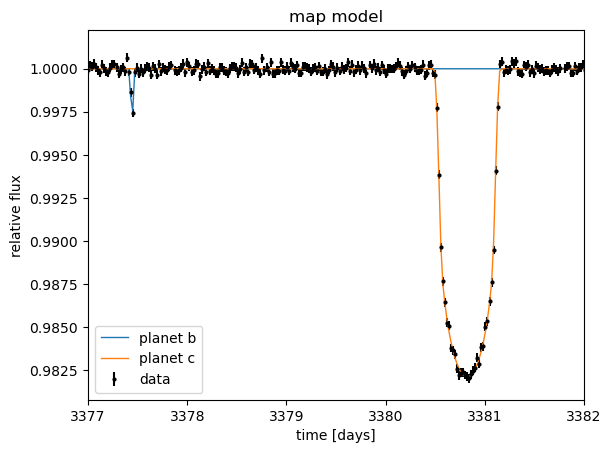

In [7]:
#plt.plot(time, flux, ".k", ms=4, label="data")
plt.errorbar(time, flux, yerr = flux_error, color = 'k', marker = ".", linestyle = 'none', ms=4, label="data")

for i, l in enumerate("bc"):
    plt.plot(
        time, map_soln["light_curves"][:,i]+map_soln["mean"], lw=1, label="planet {0}".format(l)
    )
plt.xlim(time.min(), time.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(3377, 3382)
plt.legend(fontsize=10)
_ = plt.title("map model")

# Our Initial Posteriors #

In [8]:
### Eccentric Fit ###
print('*** MAP Fit Parameters ***')
for thiskey in list(map_soln.keys())[:-1]:
    if bool(thiskey.find('__')+1):
        continue
    print('{}: {}'.format(thiskey, map_soln[thiskey]))

*** MAP Fit Parameters ***
mean: 0.9999978557550374
period: [  6.72523324 996.65056611]
t0: [2388.83460204 3380.8222041 ]
u: [ 0.66779916 -0.05069938]
m_star: 0.8206161643813047
r_star: 0.7887737309973255
teff: 4869.065063793192
st_lum: 0.31396245673473133
ror: [0.06178099 0.11909607]
r_pl: [0.04873122 0.09393985]
b: [0.93556071 0.13371036]
ecs: [[ 3.55459704e-04 -6.82582487e-07]
 [ 4.74159815e-01  2.76778879e-01]]
ecc: [0.22482766 0.07660655]
omega: [1.57004666 1.57079879]
rho_circ: 2.357404143608494
aor: [ 17.79659601 498.38005434]


# Sampling the Posteriors (above) Defined By The Model #

In [19]:
NSteps = 3000
Nchains = 4
Ncores = 5
with model:

    trace = pmx.sample(
        tune=NSteps,
        draws= int(NSteps/2),
        start=map_soln,
        cores = Ncores,
        chains = Nchains,
        target_accept=0.95,
        return_inferencedata=True,
    )
# with model:
#     trace = pmx.sample(
#         tune=1000,
#         draws=5000,
#         start=map_soln,
#         cores=5,
#         chains=4,
#         target_accept=0.95,
#         return_inferencedata=True,
#     )
    


Multiprocess sampling (4 chains in 5 jobs)
NUTS: [ecs, b, t0, period, ror, teff, r_star, m_star, u, mean]


/Users/tuca/Documents/EPIC/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tuca/Documents/EPIC/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tuca/Documents/EPIC/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tuca/Documents/EPIC/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 1_500 draw iterations (12_000 + 6_000 draws total) took 873 seconds.
There were 1103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1211 divergences after tuning. Increase `target_accept` or reparameterize.
There 

# Summary Statistics To Assess Convergence #

In [20]:
import arviz as az

az.summary(trace, var_names=["period", "t0", "ror", 'b', 'ecc','u', 'teff'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period[0],6.725,0.000,6.725,6.725,0.000,0.000,1117.0,1535.0,1.01
period[1],1335.096,276.427,996.689,1826.497,11.237,7.950,508.0,838.0,1.01
t0[0],2388.835,0.003,2388.830,2388.841,0.000,0.000,83.0,46.0,1.05
t0[1],3380.822,0.001,3380.821,3380.823,0.000,0.000,1627.0,1943.0,1.00
ror[0],0.074,0.012,0.056,0.095,0.001,0.000,264.0,278.0,1.02
ror[1],0.119,0.001,0.117,0.121,0.000,0.000,411.0,542.0,1.01
b[0],0.950,0.090,0.902,1.000,0.007,0.005,234.0,141.0,1.02
b[1],0.111,0.073,0.000,0.235,0.003,0.002,654.0,818.0,1.01
ecc[0],0.345,0.248,0.000,0.837,0.033,0.025,63.0,69.0,1.06
ecc[1],0.316,0.175,0.065,0.662,0.010,0.008,375.0,103.0,1.01


# Trace Plots (which tells us if our parameters have converged?) # 

In [22]:
# # _ = az.plot_trace(trace, var_names=["period", "t0", "ror", "b", "u", "mean"])
# _ = az.plot_trace(trace, var_names=["period", "t0", "ror", 'b', 'ecc','u', 'teff'])

# Generating Corner Plot for Parameters of Interest #
#### *Last time, I think we were wondering why there was a hard cut-off for the period parameter* ####

In [23]:
import corner

truth = dict(
    zip(
        ["period", "t0", "ror", 'b', 'ecc','u', 'teff'],
        pmx.eval_in_model([period, t0, ror, b, ecc, ustar, teff], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["period", "t0", "ror", 'b', 'ecc', 'u', 'teff'],
    truths=truth,
)


TypeError: Outputs must be theano Variable or Out instances. Received 3380.822213370987 of type <class 'numpy.float64'>

## Plotting The Model Predictions for Each Planet ##

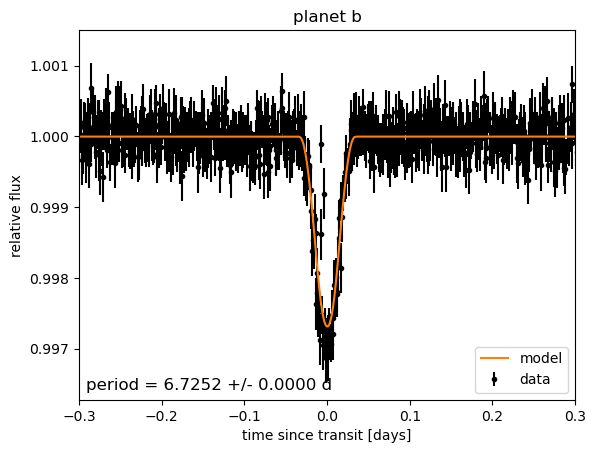

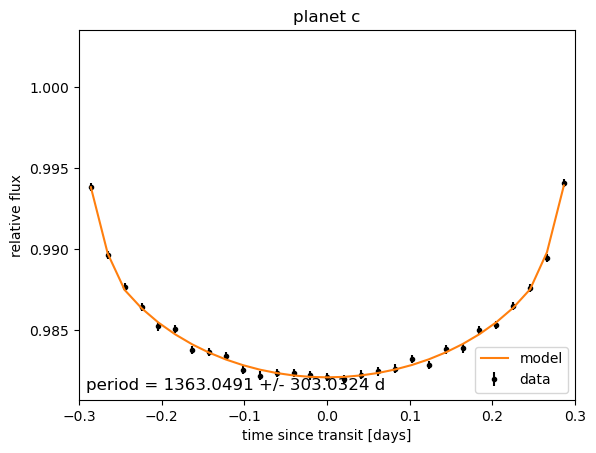

In [13]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    period_trace = trace.posterior["period"].values[:, :, n]
    p = np.median(period_trace)
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    lcs = trace.posterior["light_curves"].values
    other = np.median(lcs[:, :, :, (n + 1) % 2], axis=(0, 1))

    # Plot the folded data
    x_fold = (time - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, flux - other, yerr=flux_error, fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = lcs[:, :, inds, n] + trace.posterior["mean"].values[:, :, None]
    pred = np.median(pred, axis=(0, 1))
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(period_trace), np.std(period_trace)
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

In [14]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
#     p = np.median(flat_samps["period"][n])
#     t0 = np.median(flat_samps["t0"][n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(flat_samps["vrad"][:, (n + 1) % 2], axis=-1)
    other += np.median(flat_samps["bkg"], axis=-1)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        flat_samps["vrad_pred"][inds, n], [16, 50, 84], axis=-1
    )
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

NameError: name 'flat_samps' is not defined

<Figure size 640x480 with 0 Axes>